# Time-series Clustering Approach

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tqdm import tqdm
import numpy as np

import sys
sys.path.append('../src')
from utils import *
sys.path.remove('../src')

In [4]:
df_samples = pd.read_csv('../data/data.csv', index_col='Unnamed: 0')
display(df_samples.head(4))

df_targets = pd.read_csv('../data/target_train.csv')
df_targets['labels'] = df_targets['target'].apply(lambda x: 0 if x == 'OD' else 1)
display(df_targets)

X, y =[], []
for id in tqdm(df_targets['id']):
    sample = np.vstack([df_samples[df_samples['id'] == id]['ch0'].to_numpy(),
                        df_samples[df_samples['id'] == id]['ch1'].to_numpy(),
                        df_samples[df_samples['id'] == id]['ch2'].to_numpy()])
    target = df_targets[df_targets['id']==id]['labels']
    X.append(sample)
    y.append(target)
X = np.array(X)
y = np.array(y)
y = np.reshape(y, (y.shape[0], ))
X_train = X

,id,time,ch0,ch1,ch2
0,1_1,0,372.271894,350.219643,408.527289
1,1_1,1,373.393195,349.845876,411.143658
2,1_1,2,371.898127,350.219643,412.638726
3,1_1,3,371.898127,350.967177,413.386260


,id,target,labels
0,111_1,OD,0
1,103_1,OD,0
2,34_2,ID,1
3,78_1,OD,0
4,71_2,OD,0
...,...,...,...
95,136_1,OD,0
96,183_1,ID,1
97,26_2,OD,0
98,6_2,OD,0


100%|██████████| 100/100 [00:11<00:00,  8.92it/s]


In [5]:
seed = 42
sz = X_train.shape[1]

In [6]:
sil_sc = {'km': [],
          'dba_km': [],
          'sdtw_km': []}

clsts = range(3, 14)
for n_clusters in tqdm(clsts):
    km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
    y_pred = km.fit_predict(X_train)
    sil_sc['km'].append(silhouette_score(X_train, y_pred, metric="dtw"))
    dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    sil_sc['dba_km'].append(silhouette_score(X_train, y_pred, metric="dtw"))
    sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=False,
                           random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)
    sil_sc['sdtw_km'].append(silhouette_score(X_train, y_pred, metric="dtw"))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [07:06<00:00, 38.74s/it]


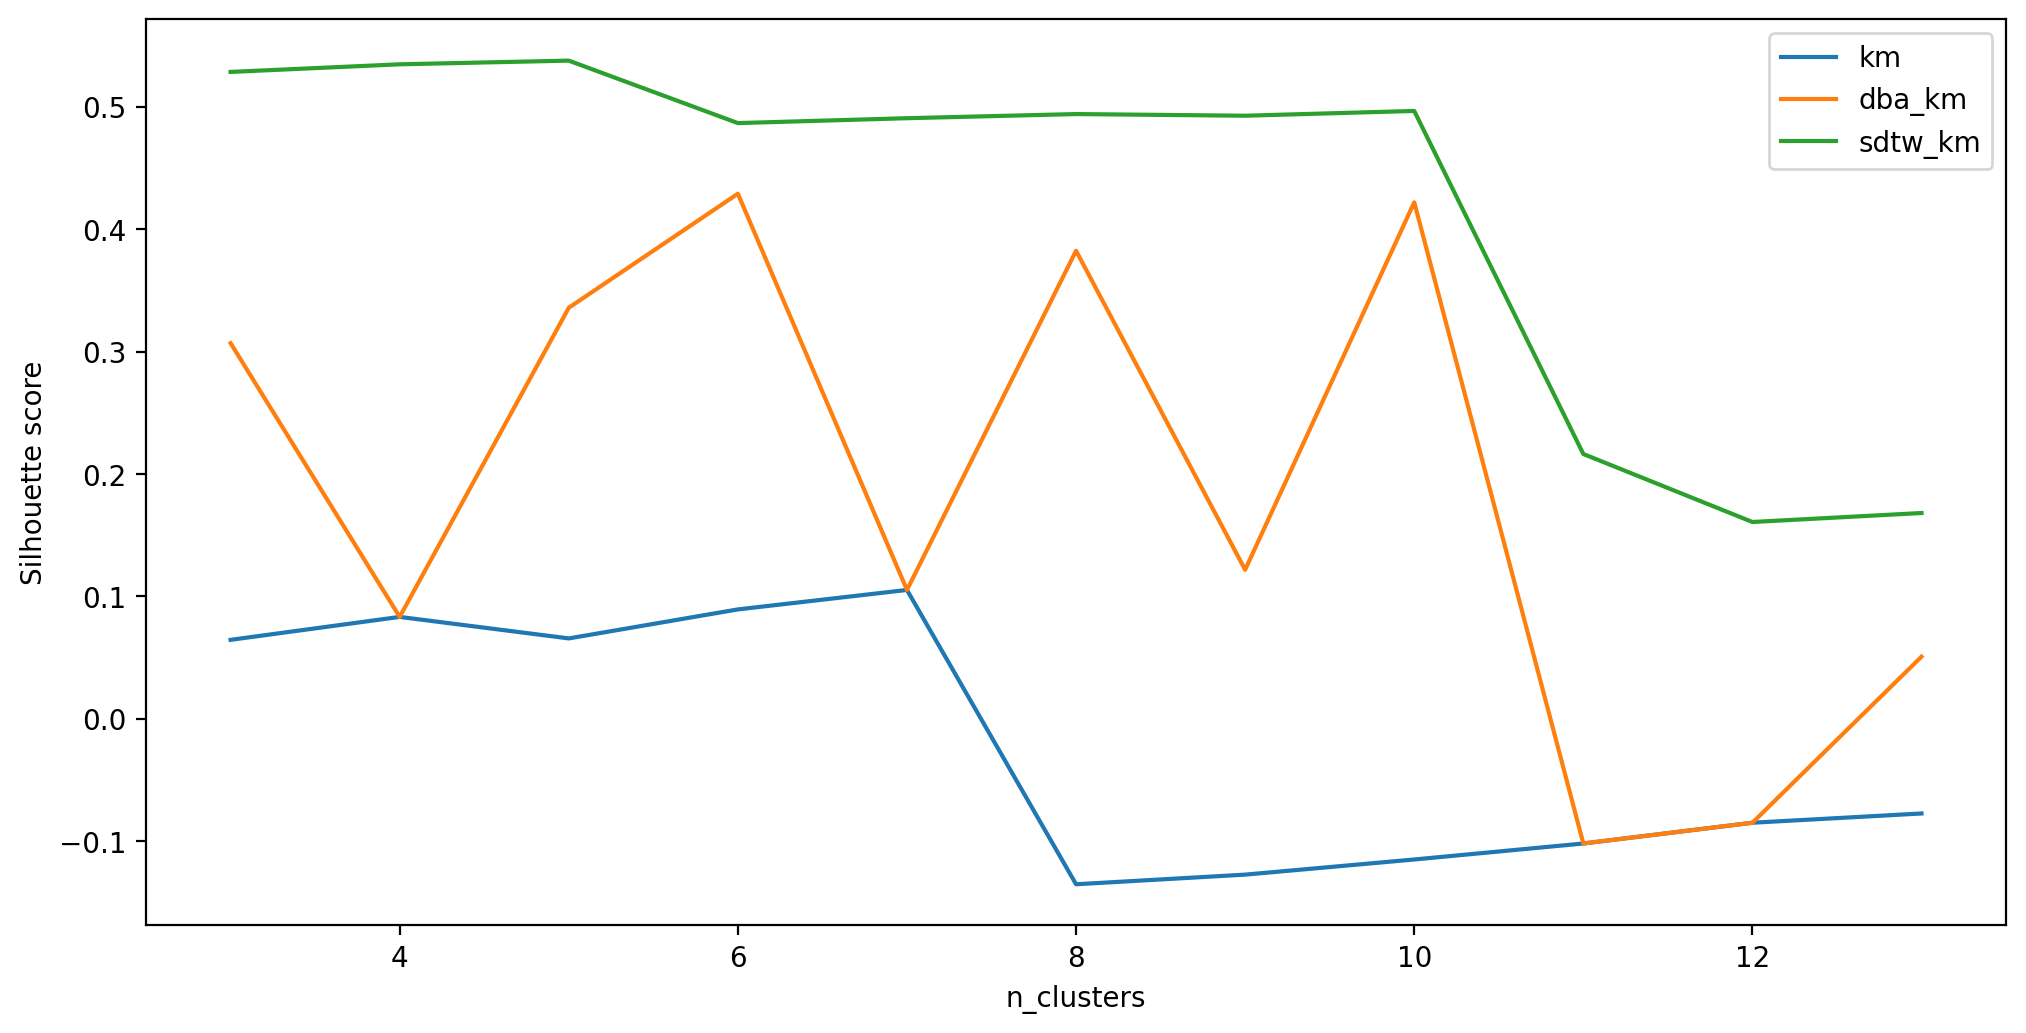

In [7]:
plt.figure(figsize=(12,6), dpi=200)
for key, item in sil_sc.items():
    plt.plot(clsts, item, label=key)
plt.xlabel('n_clusters')
plt.ylabel('Silhouette score')
plt.legend()
plt.savefig('../imgs/ts_clust_sl.png')
plt.show()

In [9]:
from sklearn.utils import resample
from scipy import stats

def conf_int(data, val=0.95):
    return stats.norm.interval(val, np.mean(data, axis=0), np.std(data, axis=0))

scores = []
variances = []
ci = []

for n_clusters in tqdm(clsts):
    sils = []
    for j in tqdm(range(50)):
        X_step = resample(X_train)
        dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
        y_pred = dba_km.fit_predict(X_step)
        sil = silhouette_score(X_step, y_pred)
        sils.append(sil)
    scores.append(np.mean(sils))
    ci.append(conf_int(sils))
    variances.append(np.var(sils))
    print(f'Number of clusters: {n_clusters}')
    print(f'\tVariance: {variances[-1]}')
    print(f'\tConfidence interval: {ci[-1]}')

ci0, ci1 = [], []
for item in ci:
    ci0.append(item[0])
    ci1.append(item[1])


  9%|▉         | 1/11 [05:52<58:46, 352.70s/it]

Number of clusters: 3
	Variance: 0.02703329885187351
	Confidence interval: (0.1454049627220934, 0.7899119194789306)


 18%|█▊        | 2/11 [13:18<1:01:08, 407.56s/it]

Number of clusters: 4
	Variance: 0.03523618519414285
	Confidence interval: (0.025731293964317448, 0.7615528876177025)


 27%|██▋       | 3/11 [22:10<1:01:53, 464.16s/it]

Number of clusters: 5
	Variance: 0.020194654797326086
	Confidence interval: (0.0921954803973023, 0.6492482060959069)


 36%|███▋      | 4/11 [30:47<56:36, 485.27s/it]  

Number of clusters: 6
	Variance: 0.026223694874135988
	Confidence interval: (0.019214405293440817, 0.6539970263077248)


 45%|████▌     | 5/11 [39:46<50:27, 504.52s/it]

Number of clusters: 7
	Variance: 0.03141107736954546
	Confidence interval: (-0.021906306160024203, 0.6728292125195551)


 55%|█████▍    | 6/11 [52:37<49:35, 595.09s/it]

Number of clusters: 8
	Variance: 0.01730726675573091
	Confidence interval: (0.10747598029423422, 0.6231702794324299)


 64%|██████▎   | 7/11 [1:06:03<44:16, 664.02s/it]

Number of clusters: 9
	Variance: 0.01879264047983591
	Confidence interval: (0.05366720318919799, 0.5910354364721084)


 73%|███████▎  | 8/11 [1:20:26<36:22, 727.44s/it]

Number of clusters: 10
	Variance: 0.016629848331222236
	Confidence interval: (0.043215913318680854, 0.5487171598405036)


 82%|████████▏ | 9/11 [1:35:55<26:20, 790.33s/it]

Number of clusters: 11
	Variance: 0.01108623819757079
	Confidence interval: (0.06904720541088932, 0.48178115125190907)


 91%|█████████ | 10/11 [1:52:51<14:20, 860.04s/it]

Number of clusters: 12
	Variance: 0.012484749103418203
	Confidence interval: (0.012885430634176104, 0.45087926423222546)


100%|██████████| 11/11 [2:11:15<00:00, 715.96s/it]

Number of clusters: 13
	Variance: 0.01167283128739449
	Confidence interval: (0.05854674530007864, 0.482059204202699)


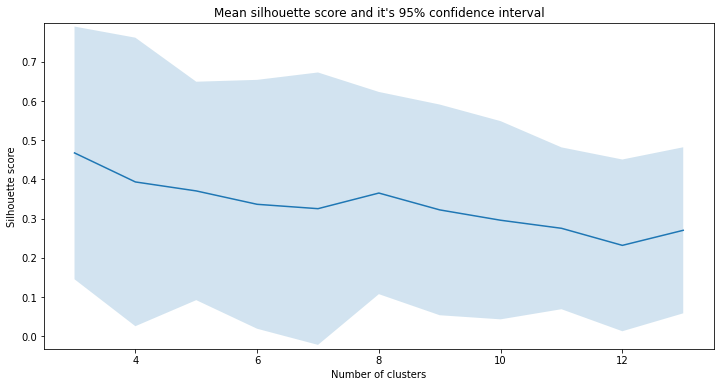

In [10]:
plt.figure(figsize=(12,6))
plt.plot(clsts, scores)
plt.fill_between(clsts, ci0, ci1, alpha=0.2)
plt.ylim(np.min(ci0)-0.01, np.max(ci1)+0.01)
plt.title("Mean silhouette score and it's 95% confidence interval")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.savefig('../imgs/ts_clust_sl_ti.png')
plt.show()
